In [15]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import json
import numpy as np

import trimesh
from PIL import Image

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:

ply_path = r"C:\Users\Priyam Mishra\Desktop\UTN Thesis\notebook\gaussians\single\chair.ply"

mesh = trimesh.load(ply_path)

if hasattr(mesh, "vertices"):
    points = np.asarray(mesh.vertices)
elif hasattr(mesh, "points"):
    points = np.asarray(mesh.points)
else:
    raise ValueError("Unsupported point cloud format")

print("Points shape:", points.shape)
print("Min:", points.min(axis=0))
print("Max:", points.max(axis=0))


Points shape: (284544, 3)
Min: [-0.29840291 -0.3328535  -0.49904558]
Max: [0.30041289 0.32970417 0.49858648]


In [17]:
def plot_points(points, title="", s=1):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.scatter(points[:, 0], points[:, 1], points[:, 2],
               s=s, alpha=0.8)

    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

    # Equal aspect ratio
    max_range = (points.max(axis=0) - points.min(axis=0)).max()
    mid = points.mean(axis=0)
    ax.set_xlim(mid[0] - max_range/2, mid[0] + max_range/2)
    ax.set_ylim(mid[1] - max_range/2, mid[1] + max_range/2)
    ax.set_zlim(mid[2] - max_range/2, mid[2] + max_range/2)

    plt.show()


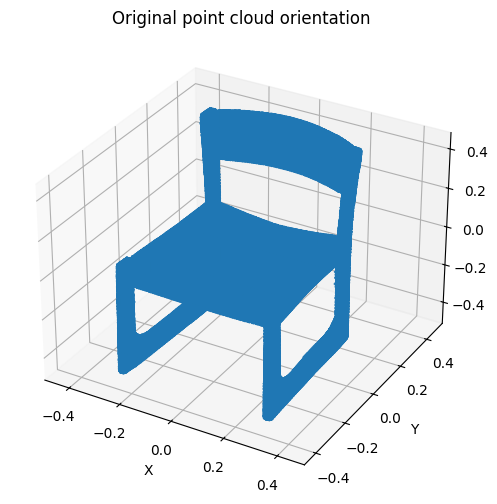

In [18]:
plot_points(points, title="Original point cloud orientation")


In [19]:
def rotate_x(points, angle_rad):
    R = np.array([
        [1, 0, 0],
        [0, np.cos(angle_rad), -np.sin(angle_rad)],
        [0, np.sin(angle_rad),  np.cos(angle_rad)]
    ])
    return points @ R.T

def rotate_y(points, angle_rad):
    R = np.array([
        [ np.cos(angle_rad), 0, np.sin(angle_rad)],
        [ 0,                1, 0               ],
        [-np.sin(angle_rad), 0, np.cos(angle_rad)]
    ])
    return points @ R.T

def rotate_z(points, angle_rad):
    R = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad), 0],
        [np.sin(angle_rad),  np.cos(angle_rad), 0],
        [0,                 0,                1]
    ])
    return points @ R.T


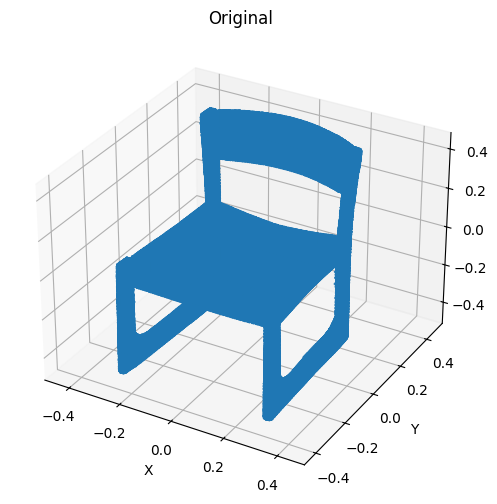

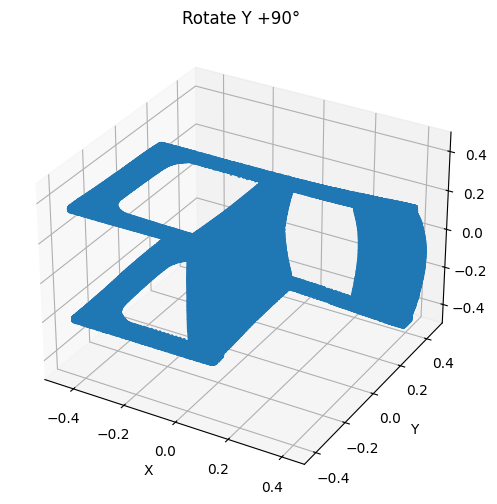

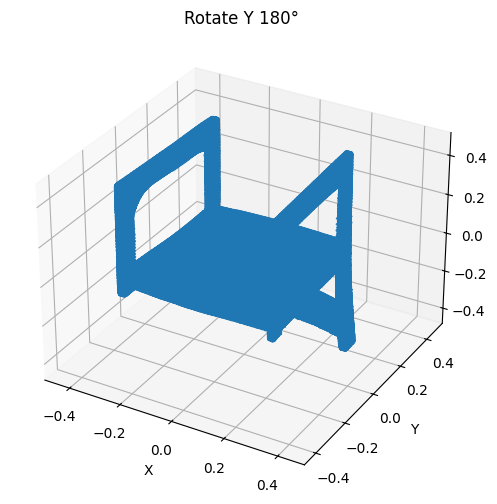

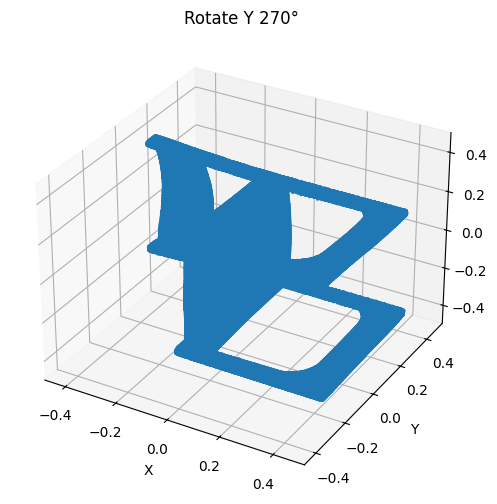

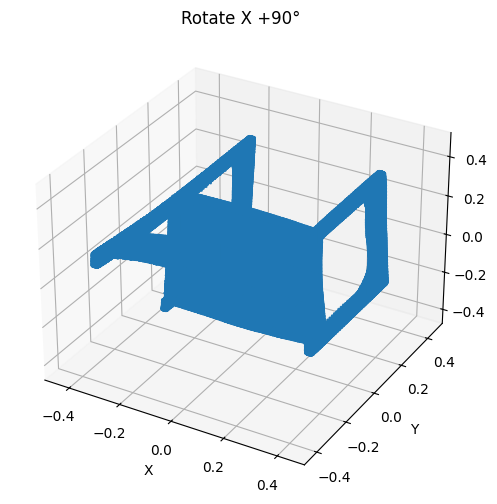

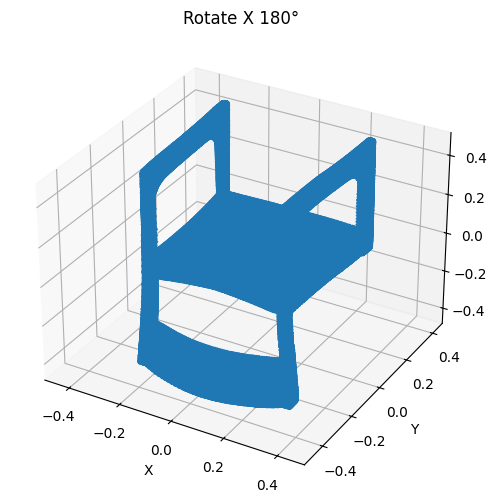

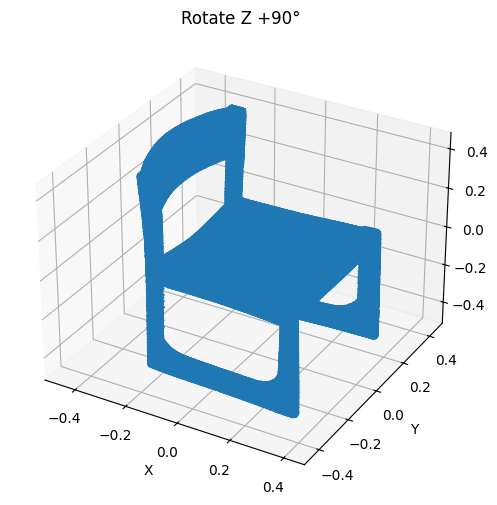

In [20]:
plot_points(points, "Original")

plot_points(rotate_y(points, np.pi/2),   "Rotate Y +90°")
plot_points(rotate_y(points, np.pi),     "Rotate Y 180°")
plot_points(rotate_y(points, 3*np.pi/2), "Rotate Y 270°")

plot_points(rotate_x(points, np.pi/2),   "Rotate X +90°")
plot_points(rotate_x(points, np.pi),     "Rotate X 180°")

plot_points(rotate_z(points, np.pi/2),   "Rotate Z +90°")


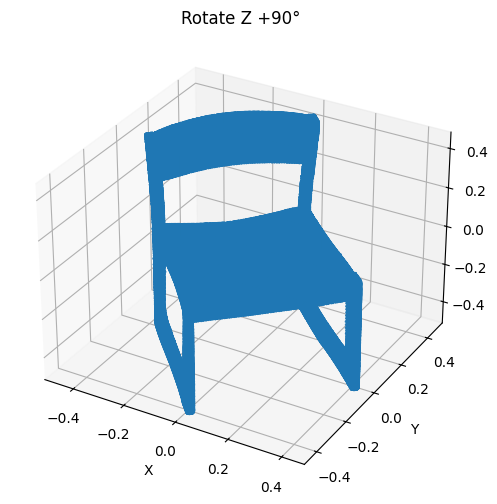

In [21]:
plot_points(rotate_z(points, np.pi/4),   "Rotate Z +90°")


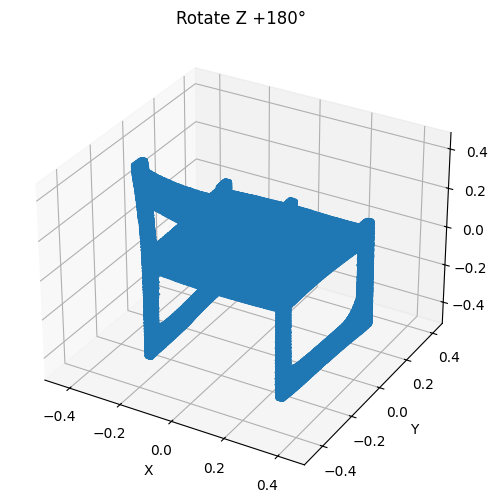

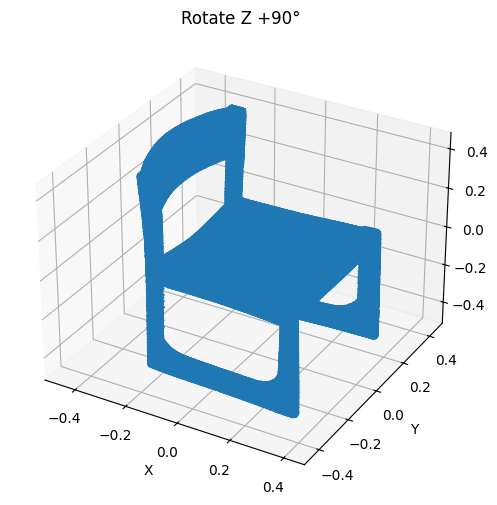

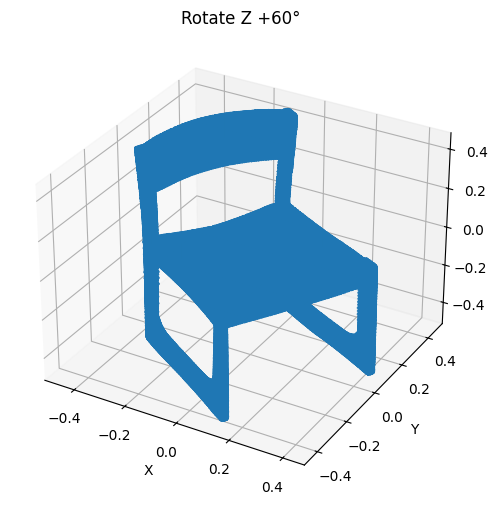

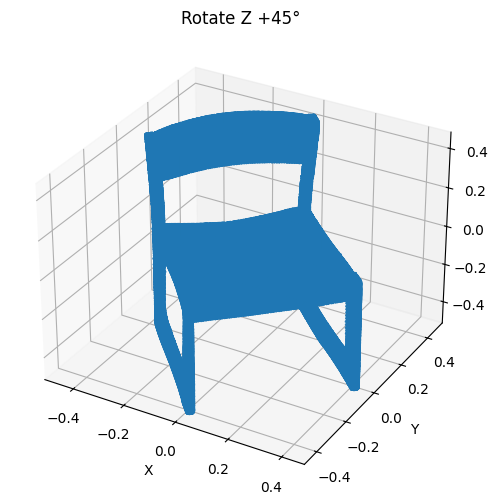

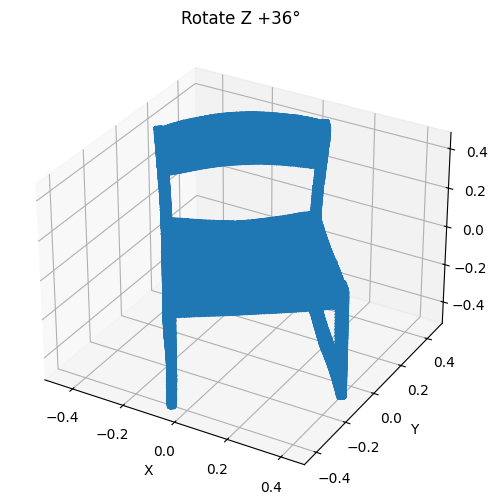

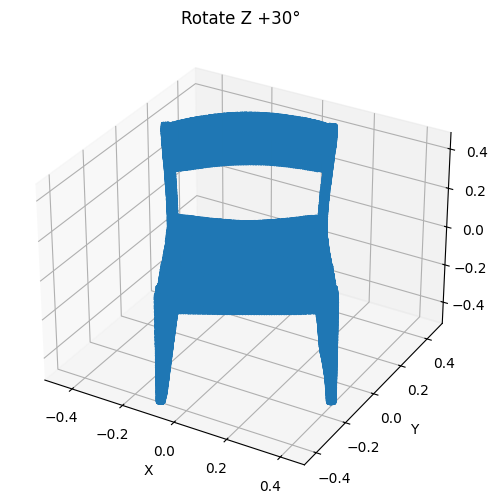

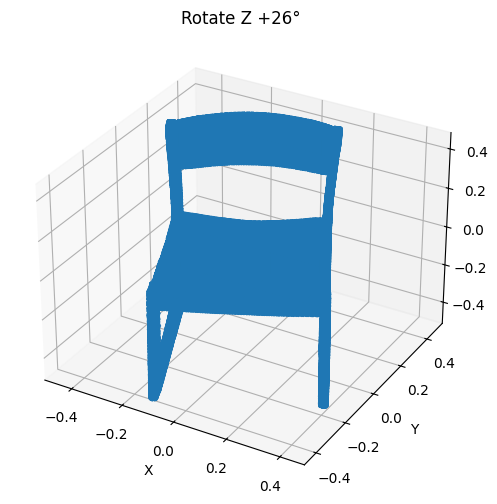

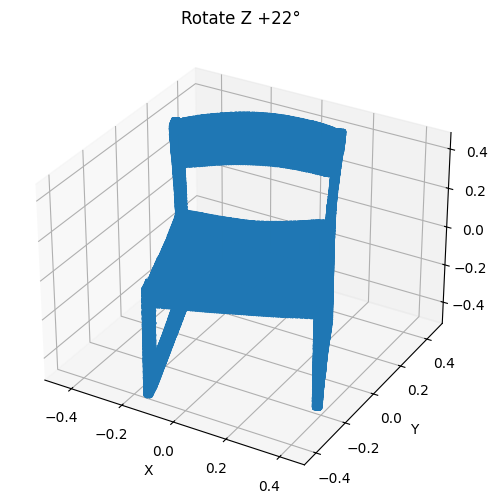

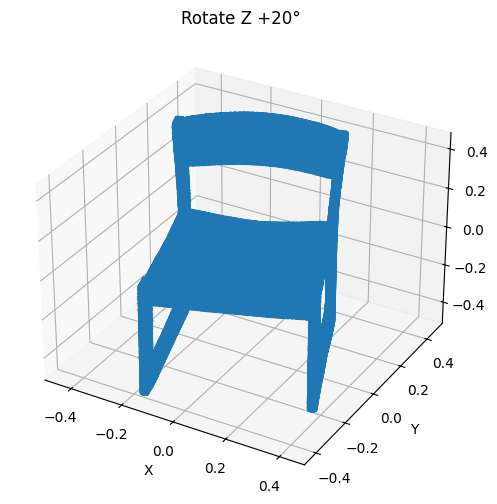

In [22]:
for i in range(1,10):
    plot_points(rotate_z(points, np.pi/i),   f"Rotate Z +{np.pi/i * 180 / np.pi:.0f}°")


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def rotate_z(points, angle_deg):
    a = np.deg2rad(angle_deg)
    R = np.array([
        [np.cos(a), -np.sin(a), 0.0],
        [np.sin(a),  np.cos(a), 0.0],
        [0.0,        0.0,       1.0]
    ], dtype=np.float32)
    return (points @ R.T).astype(np.float32), R

def project_points(points, K, w2c):
    """
    points: (N, 3)
    K: (3, 3)
    w2c: (4, 4)
    returns:
      pixels: (N, 2) float
      depths: (N,)   float (Z in camera coords)
    """
    N = points.shape[0]
    pts_h = np.hstack([points, np.ones((N, 1), dtype=np.float32)])
    pts_cam = (w2c @ pts_h.T).T
    X, Y, Z = pts_cam[:,0], pts_cam[:,1], pts_cam[:,2]

    eps = 1e-6
    Zs = np.where(np.abs(Z) < eps, eps, Z)
    x = X / Zs
    y = Y / Zs

    fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
    u = fx * x + cx
    v = fy * y + cy
    return np.stack([u, v], axis=-1).astype(np.float32), Z.astype(np.float32)

def align_projection_to_mask_bbox(pixels, mask, depths):
    """
    CFnew-style alignment:
    - compute bbox of mask pixels
    - compute bbox of projected pixels (front-facing only)
    - use UNIFORM scale = min(scale_x, scale_y)
    returns aligned_u, aligned_v
    """
    H, W = mask.shape
    ys, xs = np.where(mask > 0)
    mx_min, mx_max = xs.min(), xs.max()
    my_min, my_max = ys.min(), ys.max()

    front = depths > 0
    u = pixels[front, 0]
    v = pixels[front, 1]
    px_min, px_max = u.min(), u.max()
    py_min, py_max = v.min(), v.max()

    du = max(px_max - px_min, 1e-6)
    dv = max(py_max - py_min, 1e-6)
    mask_w = max(mx_max - mx_min, 1e-6)
    mask_h = max(my_max - my_min, 1e-6)

    scale_x = mask_w / du
    scale_y = mask_h / dv
    scale   = min(scale_x, scale_y)   # IMPORTANT: uniform scale like CFnew

    shift_x = mx_min - px_min * scale
    shift_y = my_min - py_min * scale

    aligned_u = pixels[:,0] * scale + shift_x
    aligned_v = pixels[:,1] * scale + shift_y

    debug = {
        "mask_bbox": (mx_min, mx_max, my_min, my_max),
        "proj_bbox": (px_min, px_max, py_min, py_max),
        "scale_x": scale_x, "scale_y": scale_y, "scale": scale,
        "shift_x": shift_x, "shift_y": shift_y
    }
    return aligned_u, aligned_v, debug


In [27]:
# rotate point cloud before projection
points_rot, Rz = rotate_z(points, 30.0)
print("Using Z rotation +30 deg")
print("Rz:\n", Rz)


Using Z rotation +30 deg
Rz:
 [[ 0.8660254 -0.5        0.       ]
 [ 0.5        0.8660254  0.       ]
 [ 0.         0.         1.       ]]


In [ ]:
H, W, _ = rgb.shape

pixels_raw, depths = project_points(points_rot, K, w2c)
aligned_u, aligned_v, dbg = align_projection_to_mask_bbox(pixels_raw, mask, depths)

print("Mask bbox:", dbg["mask_bbox"])
print("Proj bbox:", dbg["proj_bbox"])
print("Scale:", dbg["scale"], " (scale_x:", dbg["scale_x"], "scale_y:", dbg["scale_y"], ")")
